In [1]:
from flowAnalyzer import FlowAnalysis
import pandas as pd
import copy
import glob
import matplotlib
import numpy as np
import os
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [2]:
in_folder = "HSV1_Data/Rep*/"
outfolder = "HSV1_Results/"
virus = 'HSV-$\mathregular{1^{+}}$'
fa = FlowAnalysis(quiet=False)

In [3]:
individuals = True
samples = [('AT8', 'Replicate 1')]
#samples = [('Aducanumab', 'Replicate 1'), ('6E10', 'Replicate 1')]

In [4]:
import pandas as pd

def filter_df(data: pd.DataFrame, samples: list[tuple], keep=True) -> pd.DataFrame:
    """
    Filters the DataFrame to include only columns where the values in the
    'Marker' and 'Replicate' rows match the provided tuples in samples.
    
    Parameters:
    - data: pd.DataFrame - The input DataFrame
    - samples: list of tuples - Each tuple contains (Marker, Replicate)
    - keep: bool - Whether to keep (True) or exclude (False) matching columns
    
    Returns:
    - pd.DataFrame - Filtered DataFrame
    """
    if 'Marker' in data.index and 'Replicate' in data.index:
        # If Marker and Replicate are in the index, use .loc
        matching_cols = [
            (data.loc['Marker', col], data.loc['Replicate', col]) in samples for col in data.columns
        ]
        matching_cols = pd.Series(matching_cols, index=data.columns)  # Convert to a Pandas Series
        return data.loc[:, matching_cols] if keep else data.loc[:, ~matching_cols]

    elif 'Marker' in data.columns and 'Replicate' in data.columns:
        # If Marker and Replicate are columns
        matching_rows = data[['Marker', 'Replicate']].apply(tuple, axis=1).isin(samples)
        return data[matching_rows] if keep else data[~matching_rows]

    else:
        raise KeyError("Neither 'Marker' nor 'Replicate' found in index or columns.")


In [5]:
data = pd.read_csv('HSV1_Results/valid_cells_flow_values.csv', dtype = {'Marker': str})
if individuals:
    data = filter_df(data, samples)

In [6]:
category_order = ['Mock', 'Infected', 'Treated']
group = ['Marker', 'Replicate']
data.groupby(group).size()

Marker  Replicate  
AT8     Replicate 1    66168
dtype: int64

In [7]:
data = fa.apply_function(data = data, function='gate', group = group,
                         channel='Pacific Blue-A', gate_on='Mock',
                         category_order=category_order,
                         high=85, plot_title=f'Marker|Replicate', 
                         plot_path=f'{outfolder}/Marker/Replicate', show=False, kept_max=85) 
data['Viable'] = ['Dead' if v else 'Live' for v in data['gate Pacific Blue-A']]
group.append('Viable')
data = fa.apply_function(data = data, function='gate', group = group,
                         channel='Alexa Fluor 488-A', gate_on='Infected',
                         category_order=category_order,
                         high=85, plot_title=f'Marker|Replicate|Viable', 
                         plot_path=f'{outfolder}/Marker/Replicate/Viable', show=False, mid_percentile=99, secondary_gate='Treated',kept_max=85) 
data = fa.apply_function(data = data, function='gate', group = group,
                         channel='Alexa Fluor 647-A', gate_on='Mock',
                         category_order=category_order, secondary_gate='Treated',
                         high=85, plot_title=f'Marker|Replicate|Viable', 
                         plot_path=f'{outfolder}/Marker/Replicate/Viable', show=False, kept_max=85) 


('AT8', 'Replicate 1')
15.030769911896225
One Peak
('AT8', 'Replicate 1', 'Dead')
40.71879553181156
Two Peaks-1st condition
('AT8', 'Replicate 1', 'Live')
16.20662110588444
Two Peaks-1st condition
('AT8', 'Replicate 1', 'Dead')
15.202602780242533
One Peak
('AT8', 'Replicate 1', 'Live')
15.101615424700366
One Peak


In [8]:
if not individuals:
    data.to_csv(f'{outfolder}/liveDead_cells_gated_cells_flow_values.csv', index=False)
else:
    old_data = pd.read_csv(f'{outfolder}/liveDead_cells_gated_cells_flow_values.csv', dtype={"Marker": str})
    old_data = filter_df(old_data, samples, False)
    old_data = pd.concat((old_data, data))
    old_data.to_csv(f'{outfolder}/liveDead_cells_gated_cells_flow_values.csv', index=False)
data

Alexa Fluor 488-A  Alexa Fluor 647-A  Pacific Blue-A     FSC-A  \
0                  507.0              466.0           823.0  2.423246   
1                  843.0              550.0           810.0  2.303196   
2                  832.0              600.0           776.0  2.394452   
3                  388.0              378.0           784.0  2.049218   
4                  625.0              516.0           693.0  2.305351   
...                  ...                ...             ...       ...   
47262              347.0              291.0           410.0  2.409933   
47263              314.0              461.0           392.0  1.991226   
47264              673.0              651.0           455.0  2.230449   
47265              262.0              778.0           379.0  1.968483   
47266              342.0              452.0           408.0  2.220108   

          FSC-H     SSC-A     SSC-H Marker Condition    Replicate  gate FSC-A  \
0      2.346353  2.285557  2.225309    AT8  Infected  Replicate 1        True   
1      2.247973  2.359835  2.240549    AT8  Infected  Replicate 1        True   
2      2.283301  2.136721  1.991226    AT8  Infected  Replicate 1        True   
3      2.025306  2.130334  2.096910    AT8  Infected  Replicate 1        True   
4      2.235528  2.342423  2.220108    AT8  Infected  Replicate 1        True   
...         ...       ...       ...    ...       ...          ...         ...   
47262  2.367356  2.204120  2.158362    AT8   Treated  Replicate 1        True   
47263  1.903090  2.167317  2.045323    AT8   Treated  Replicate 1        True   
47264  2.117271  2.334454  2.217484    AT8   Treated  Replicate 1        True   
47265  1.838849  1.880814  1.763428    AT8   Treated  Replicate 1        True   
47266  2.143015  2.201397  2.100371    AT8   Treated  Replicate 1        True   

       BGM  gate SSC-A  predicted  residuals  Singlet  gate Pacific Blue-A  \
0      NaN        True   2.331309   0.015044     True                 True   
1      NaN        True   2.213307   0.034667     True                 True   
2      NaN        True   2.303006  -0.019704     True                 True   
3      NaN        True   1.963661   0.061645     True                 True   
4      NaN        True   2.215425   0.020103     True                 True   
...    ...         ...        ...        ...      ...                  ...   
47262  NaN        True   2.322560   0.044796     True                False   
47263  NaN        True   1.916136  -0.013046     True                False   
47264  NaN        True   2.148341  -0.031070     True                False   
47265  NaN        True   1.894060  -0.055211     True                False   
47266  NaN        True   2.138304   0.004711     True                False   

      Viable  gate Alexa Fluor 488-A  gate Alexa Fluor 647-A  
0       Dead                   False                   False  
1       Dead                    True                    True  
2       Dead                    True                    True  
3       Dead                   False                   False  
4       Dead                   False                   False  
...      ...                     ...                     ...  
47262   Live                   False                   False  
47263   Live                   False                   False  
47264   Live                    True                    True  
47265   Live                   False                    True  
47266   Live                   False                   False  

[66168 rows x 20 columns]

In [9]:
#label each cell as live or dead based on Pacific Blue-A gate
corrected_df = pd.read_csv('HSV1_Results/all_cells_linear_corrected_values.csv', dtype={'Marker': str})
corrected_df['Viable'] = ['Dead' if v else 'Live' for v in corrected_df['gate Pacific Blue-A']]
if individuals:
    corrected_df = filter_df(corrected_df, samples)
if 'Viable' not in group:
    group.append('Viable')

correlations_df = fa.apply_function(data=corrected_df, function='calc_correlation',
                                    group = group,
                                    category_order=category_order,
                                    control_channel=None,
                                    cols=['Normalized Alexa Fluor 488-A', 'Corrected Alexa Fluor 647-A'],
                                    rows=['Corrected Alexa Fluor 647-A', 'Corrected Pacific Blue-A'],
                                    col_labels= [virus, 'Marker'], 
                                    row_labels = ['Marker', 'Dead'],
                                    plot_title='Marker|Replicate|Viable', 
                                    plot_path=f'{outfolder}/Marker/Replicate/Viable',
                                    show=False, include_colorbar=False
                        )

if not individuals:
    correlations_df.to_csv(f'{outfolder}/liveDead_cells_correlations.csv', index=False)
else:
    old_data = pd.read_csv(f'{outfolder}/liveDead_cells_correlations.csv', dtype={"Marker": str})
    old_data = filter_df(old_data, samples, False)
    old_data = pd.concat((old_data, correlations_df))
    old_data.to_csv(f'{outfolder}/liveDead_cells_correlations.csv', index=False)




('AT8', 'Replicate 1', 'Dead')
('AT8', 'Replicate 1', 'Live')


In [10]:
corrected_df['Normalized Alexa Fluor 488-A'].min()

3.0

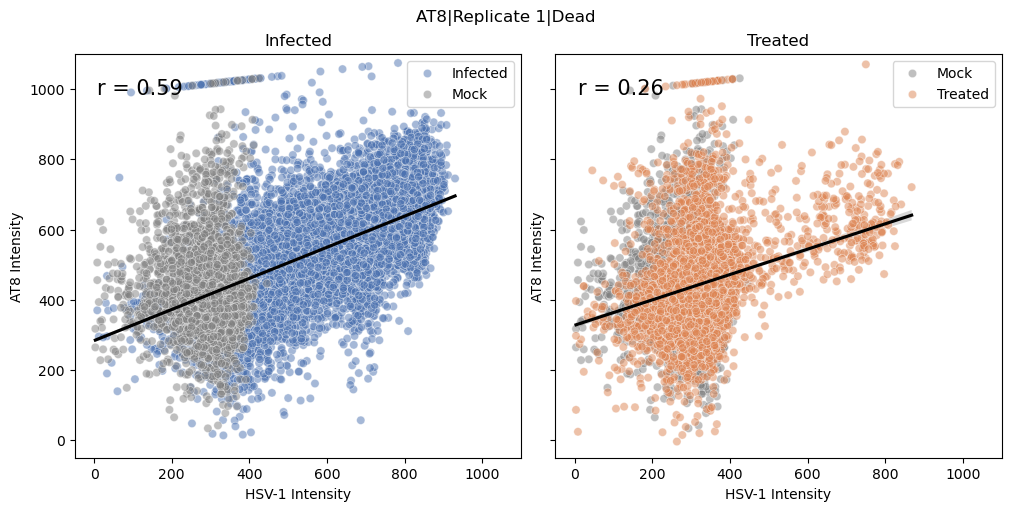

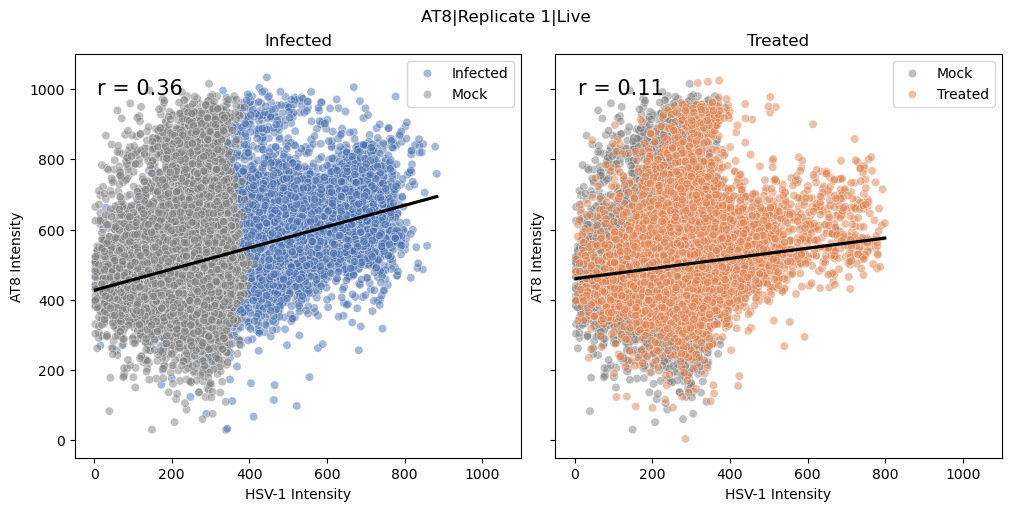

In [11]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

custom_palette = {
    'Infected': '#4C72B0',
    'Treated': '#DD8452',
    'Mock': 'gray'
}
for (marker, rep, viable), df in corrected_df.groupby(['Marker', 'Replicate', 'Viable']):
    marker = str(marker)
    fig, axes = plt.subplots(ncols=2, figsize=(10,5), sharex=True, sharey=True, 
                             gridspec_kw={'width_ratios':[1,1]}, constrained_layout=True)
    for condition, ax in zip(['Infected', 'Treated'],axes):
        ax.set_xlim(-50, 1100)
        ax.set_ylim(-50, 1100)
        marker_label = marker.replace(':', '/')
        condition_data = df[(df.Condition==condition)|(df.Condition=='Mock')]
        x = condition_data['Normalized Alexa Fluor 488-A']
        y = condition_data['Corrected Alexa Fluor 647-A']
        if len(x) < 1 or len(y) < 1:
            continue
        r,p = stats.pearsonr(x,y)
        
        sns.regplot(condition_data, x= 'Normalized Alexa Fluor 488-A', y='Corrected Alexa Fluor 647-A', ax=ax,
                    scatter=False, color='k')
        sns.scatterplot(condition_data, x= 'Normalized Alexa Fluor 488-A', y='Corrected Alexa Fluor 647-A', ax=ax,
                        alpha=0.5, hue='Condition', palette=custom_palette
             )
        
        ax.set_title(condition)
        ax.set_xlabel('HSV-1 Intensity')
        ax.set_ylabel(f'{marker} Intensity')
        ax.text(.05, .9, 'r = {:.2f}'.format(r, p),
            transform=ax.transAxes, size=15
               )
        ax.legend(loc='upper right')
    out_path = f'{outfolder}/{marker}/{rep}/{viable}/'
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    
    plt.suptitle(f'{marker_label}|{rep}|{viable}')
    #plt.tight_layout(rect=[0, 0, 1, 0.99])
    #plt.tight_layout()
    plt.savefig(f'{out_path}/correlation_scatter_plot.png', dpi=700, transparent=True)
    
    plt.show()
    #break

In [12]:
umap_df = fa.apply_function(data=data, function='calc_umap',
                           group = group)
if not individuals:
    umap_df.to_csv(f'{outfolder}/liveDead_cells_umap.csv', index=False)
else:
    old_data = pd.read_csv(f'{outfolder}/liveDead_cells_umap.csv', dtype={"Marker": str})
    old_data = filter_df(old_data, samples, False)
    old_data = pd.concat((old_data, umap_df))
    old_data.to_csv(f'{outfolder}/liveDead_cells_umap.csv', index=False)
umap_df

('AT8', 'Replicate 1', 'Dead')
('AT8', 'Replicate 1', 'Live')


FSC-A     FSC-H     SSC-A     SSC-H Marker Condition    Replicate  \
0      2.423246  2.346353  2.285557  2.225309    AT8  Infected  Replicate 1   
1      2.303196  2.247973  2.359835  2.240549    AT8  Infected  Replicate 1   
2      2.394452  2.283301  2.136721  1.991226    AT8  Infected  Replicate 1   
3      2.049218  2.025306  2.130334  2.096910    AT8  Infected  Replicate 1   
4      2.305351  2.235528  2.342423  2.220108    AT8  Infected  Replicate 1   
...         ...       ...       ...       ...    ...       ...          ...   
47262  2.409933  2.367356  2.204120  2.158362    AT8   Treated  Replicate 1   
47263  1.991226  1.903090  2.167317  2.045323    AT8   Treated  Replicate 1   
47264  2.230449  2.117271  2.334454  2.217484    AT8   Treated  Replicate 1   
47265  1.968483  1.838849  1.880814  1.763428    AT8   Treated  Replicate 1   
47266  2.220108  2.143015  2.201397  2.100371    AT8   Treated  Replicate 1   

       gate FSC-A  BGM  gate SSC-A  ...  Singlet  gate Pacific Blue-A  Viable  \
0            True  NaN        True  ...     True                 True    Dead   
1            True  NaN        True  ...     True                 True    Dead   
2            True  NaN        True  ...     True                 True    Dead   
3            True  NaN        True  ...     True                 True    Dead   
4            True  NaN        True  ...     True                 True    Dead   
...           ...  ...         ...  ...      ...                  ...     ...   
47262        True  NaN        True  ...     True                False    Live   
47263        True  NaN        True  ...     True                False    Live   
47264        True  NaN        True  ...     True                False    Live   
47265        True  NaN        True  ...     True                False    Live   
47266        True  NaN        True  ...     True                False    Live   

       gate Alexa Fluor 488-A gate Alexa Fluor 647-A  Alexa Fluor 488-A  \
0                       False                  False           0.543689   
1                        True                   True           0.906149   
2                        True                   True           0.894283   
3                       False                  False           0.415318   
4                       False                  False           0.670982   
...                       ...                    ...                ...   
47262                   False                  False           0.390909   
47263                   False                  False           0.353409   
47264                    True                   True           0.761364   
47265                   False                   True           0.294318   
47266                   False                  False           0.385227   

       Alexa Fluor 647-A  Pacific Blue-A      UMAP1      UMAP2  
0               0.451232        0.849057   9.859081  10.662378  
1               0.533990        0.818396   5.566818  12.810225  
2               0.583251        0.738208   5.287980  13.102340  
3               0.364532        0.757075  11.549766   7.220041  
4               0.500493        0.542453   3.829816   9.968030  
...                  ...             ...        ...        ...  
47262           0.275248        0.886214  -2.492906  -2.624423  
47263           0.443564        0.846827  -0.188697   0.453787  
47264           0.631683        0.984683  14.537135   4.870146  
47265           0.757426        0.818381   6.255249  11.412881  
47266           0.434653        0.881838   1.175700  -1.733776  

[66168 rows x 22 columns]

In [13]:
fa.apply_function(data=umap_df, function='plot_umap',
                 group=group,
                  plot_path=f'{outfolder}/Marker/Replicate/Viable', show=False, 
                  category_order = category_order, channel_labels=['Marker', virus, 'Dead']
                 )

('AT8', 'Replicate 1', 'Dead')
('AT8', 'Replicate 1', 'Live')


In [14]:
#data = pd.read_csv('HSV1_Results/liveDead_cells_gated_cells_flow_values.csv', dtype={'Marker': str})
#corrected_df = pd.read_csv('HSV1_Results/liveDead_cells_linear_corrected_values.csv', dtype={'Marker':str})
#category_order = ['Mock', 'Infected', 'Treated']
#group = ['Marker', 'Replicate', 'Viable']

In [15]:
#label each cell as live or dead based on Pacific Blue-A gate
quad_data = fa.apply_function(data=data, function='assign_quadrants',
                         group = group,
                         category_order=category_order,
                         plot_title=f'Marker|Replicate|Viable', 
                         plot_path=f'{outfolder}/Marker/Replicate/Viable', 
                         show=False
                        )


if not individuals:
    quad_data.to_csv(f'{outfolder}/liveDead_cells_quadrant_counts.csv', index=False)
else:
    old_data = pd.read_csv(f'{outfolder}/liveDead_cells_quadrant_counts.csv', dtype={"Marker": str})
    old_data = filter_df(old_data, samples, False)
    old_data = pd.concat((old_data, quad_data))
    old_data.to_csv(f'{outfolder}/liveDead_cells_quadrant_counts.csv', index=False)

('AT8', 'Replicate 1', 'Dead')
('AT8', 'Replicate 1', 'Live')


In [16]:
file = f'HSV1_Results/liveDead_cells_quadrant_counts.csv'
df = pd.read_csv(file, dtype={'Marker': str})
#Exclude non-cell type markers
markers = ['TRA-1-60','Nestin', 'EOMES','TuJ1','NeuN','VMAT2','GFAP','GLAST', 'Iba1', 'P2RY12', 'CD4','CD45', 'OLIG1:2:3', 'O4', 'O1', 'FOXA2']
df = df[df.Marker.isin(markers)]
dfs = []

for group, g_df in df.groupby(['Marker', 'Replicate', 'Viable']):
    
 
    g_df = g_df.set_index('Condition')
    q1 = g_df.at['Mock', 'Q1']
    q2 = g_df.at['Infected', 'Q2']
    q3 = g_df.at['Infected', 'Q3']
    q4 = g_df.at['Mock', 'Q4']
    table = np.array([[q2,q3], [q1,q4]])
    res = stats.contingency.odds_ratio(table)
    OR_inf = res.statistic
    CI_inf = res.confidence_interval(confidence_level=0.95)
    res = stats.fisher_exact(table)
    pval_inf = res.pvalue
    
    
    q1_uninf = g_df.at['Mock', 'Q1']
    q1_acv = g_df.at['Treated', 'Q1']
    q4_acv = g_df.at['Treated', 'Q4']
    q4_uninf = g_df.at['Mock', 'Q4']
    res = stats.contingency.odds_ratio(np.array([[q1_acv,q4_acv],[q1_uninf,q4_uninf]]))
    OR_acv = res.statistic
    CI_acv = res.confidence_interval(confidence_level=0.95)
    res = stats.fisher_exact(np.array([[q1_acv,q4_acv],[q1_uninf,q4_uninf]]))
    pval_acv = res.pvalue
    g_df['OR'] = ''
    g_df['CI'] = ''
    g_df['pval'] = ''
    g_df['OR'] = g_df['OR'].replace({'':np.NaN})
    g_df['pval'] = g_df['pval'].replace({'':np.NaN})
    
    g_df.at['Infected', 'OR'] = OR_inf
    g_df.at['Infected', 'CI'] = CI_inf
    g_df.at['Infected', 'pval'] = pval_inf
    g_df.at['Treated', 'OR'] = OR_acv
    g_df.at['Treated', 'CI'] = CI_acv
    g_df.at['Treated', 'pval'] = pval_acv
    dfs.append(g_df)
    
df = pd.concat(dfs)
df = df.reset_index()
df.to_csv(f'HSV1_Results/liveDead_cells_odds_ratios.csv', index=False)  



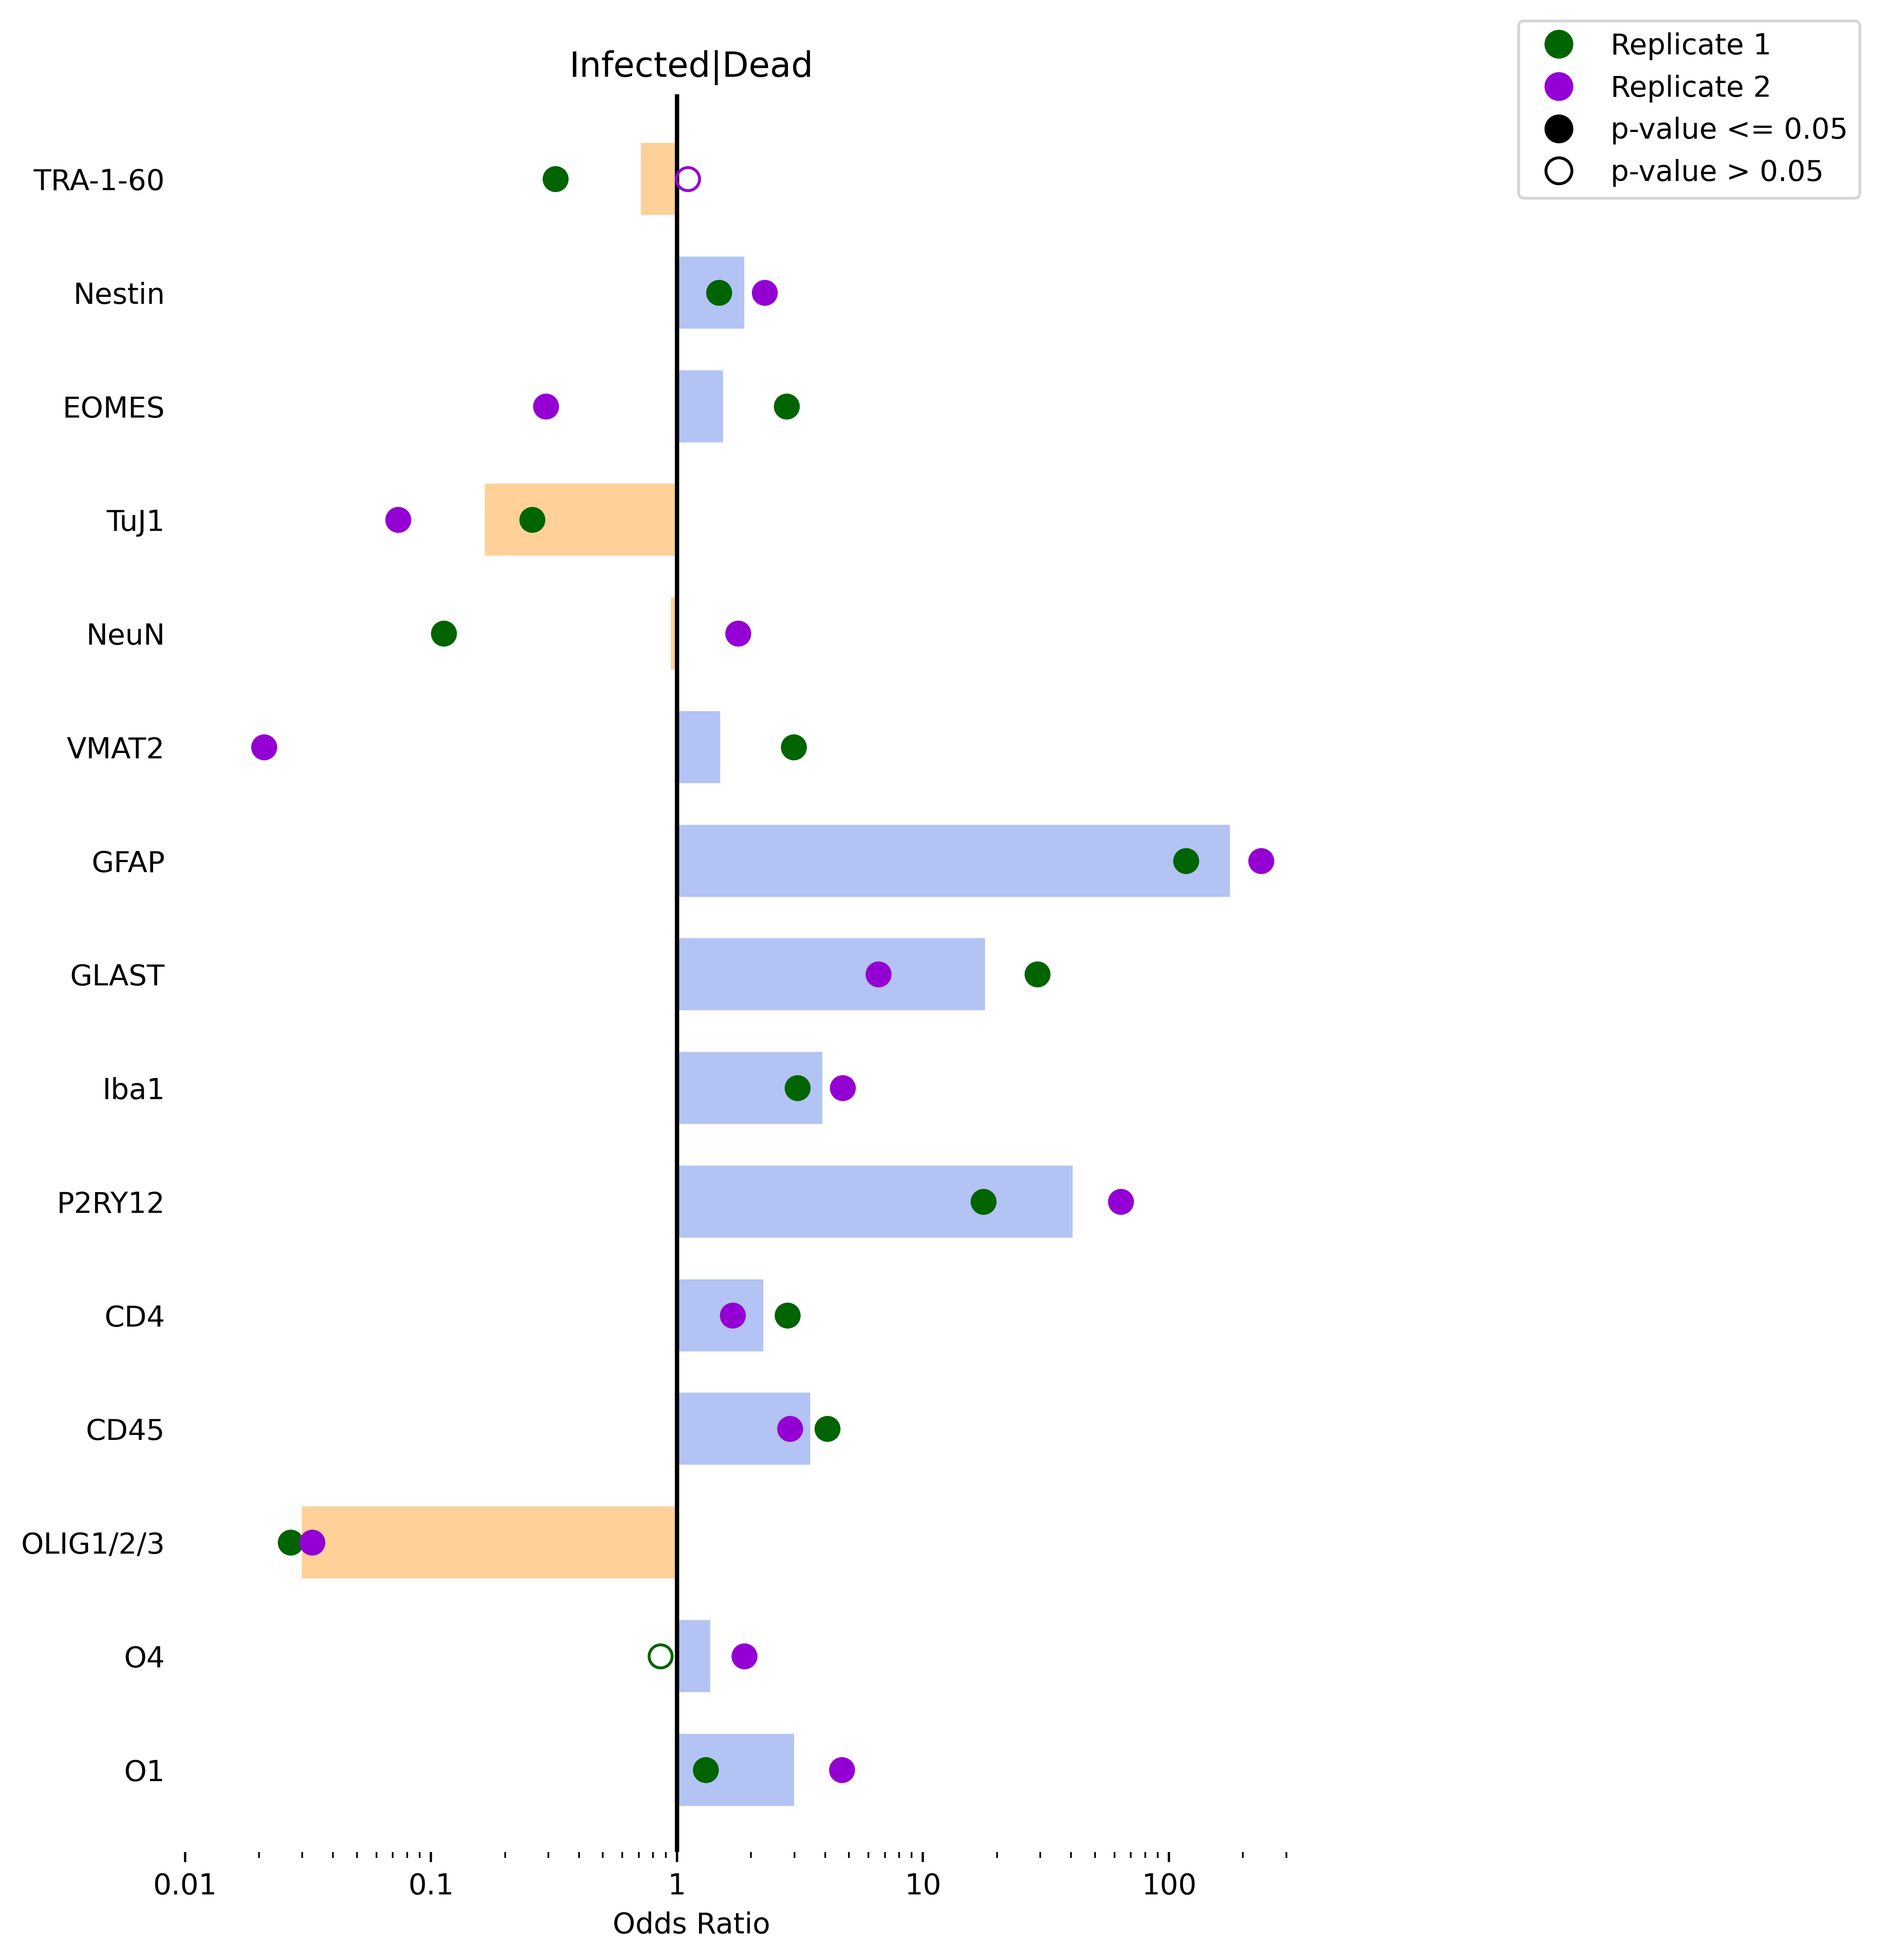

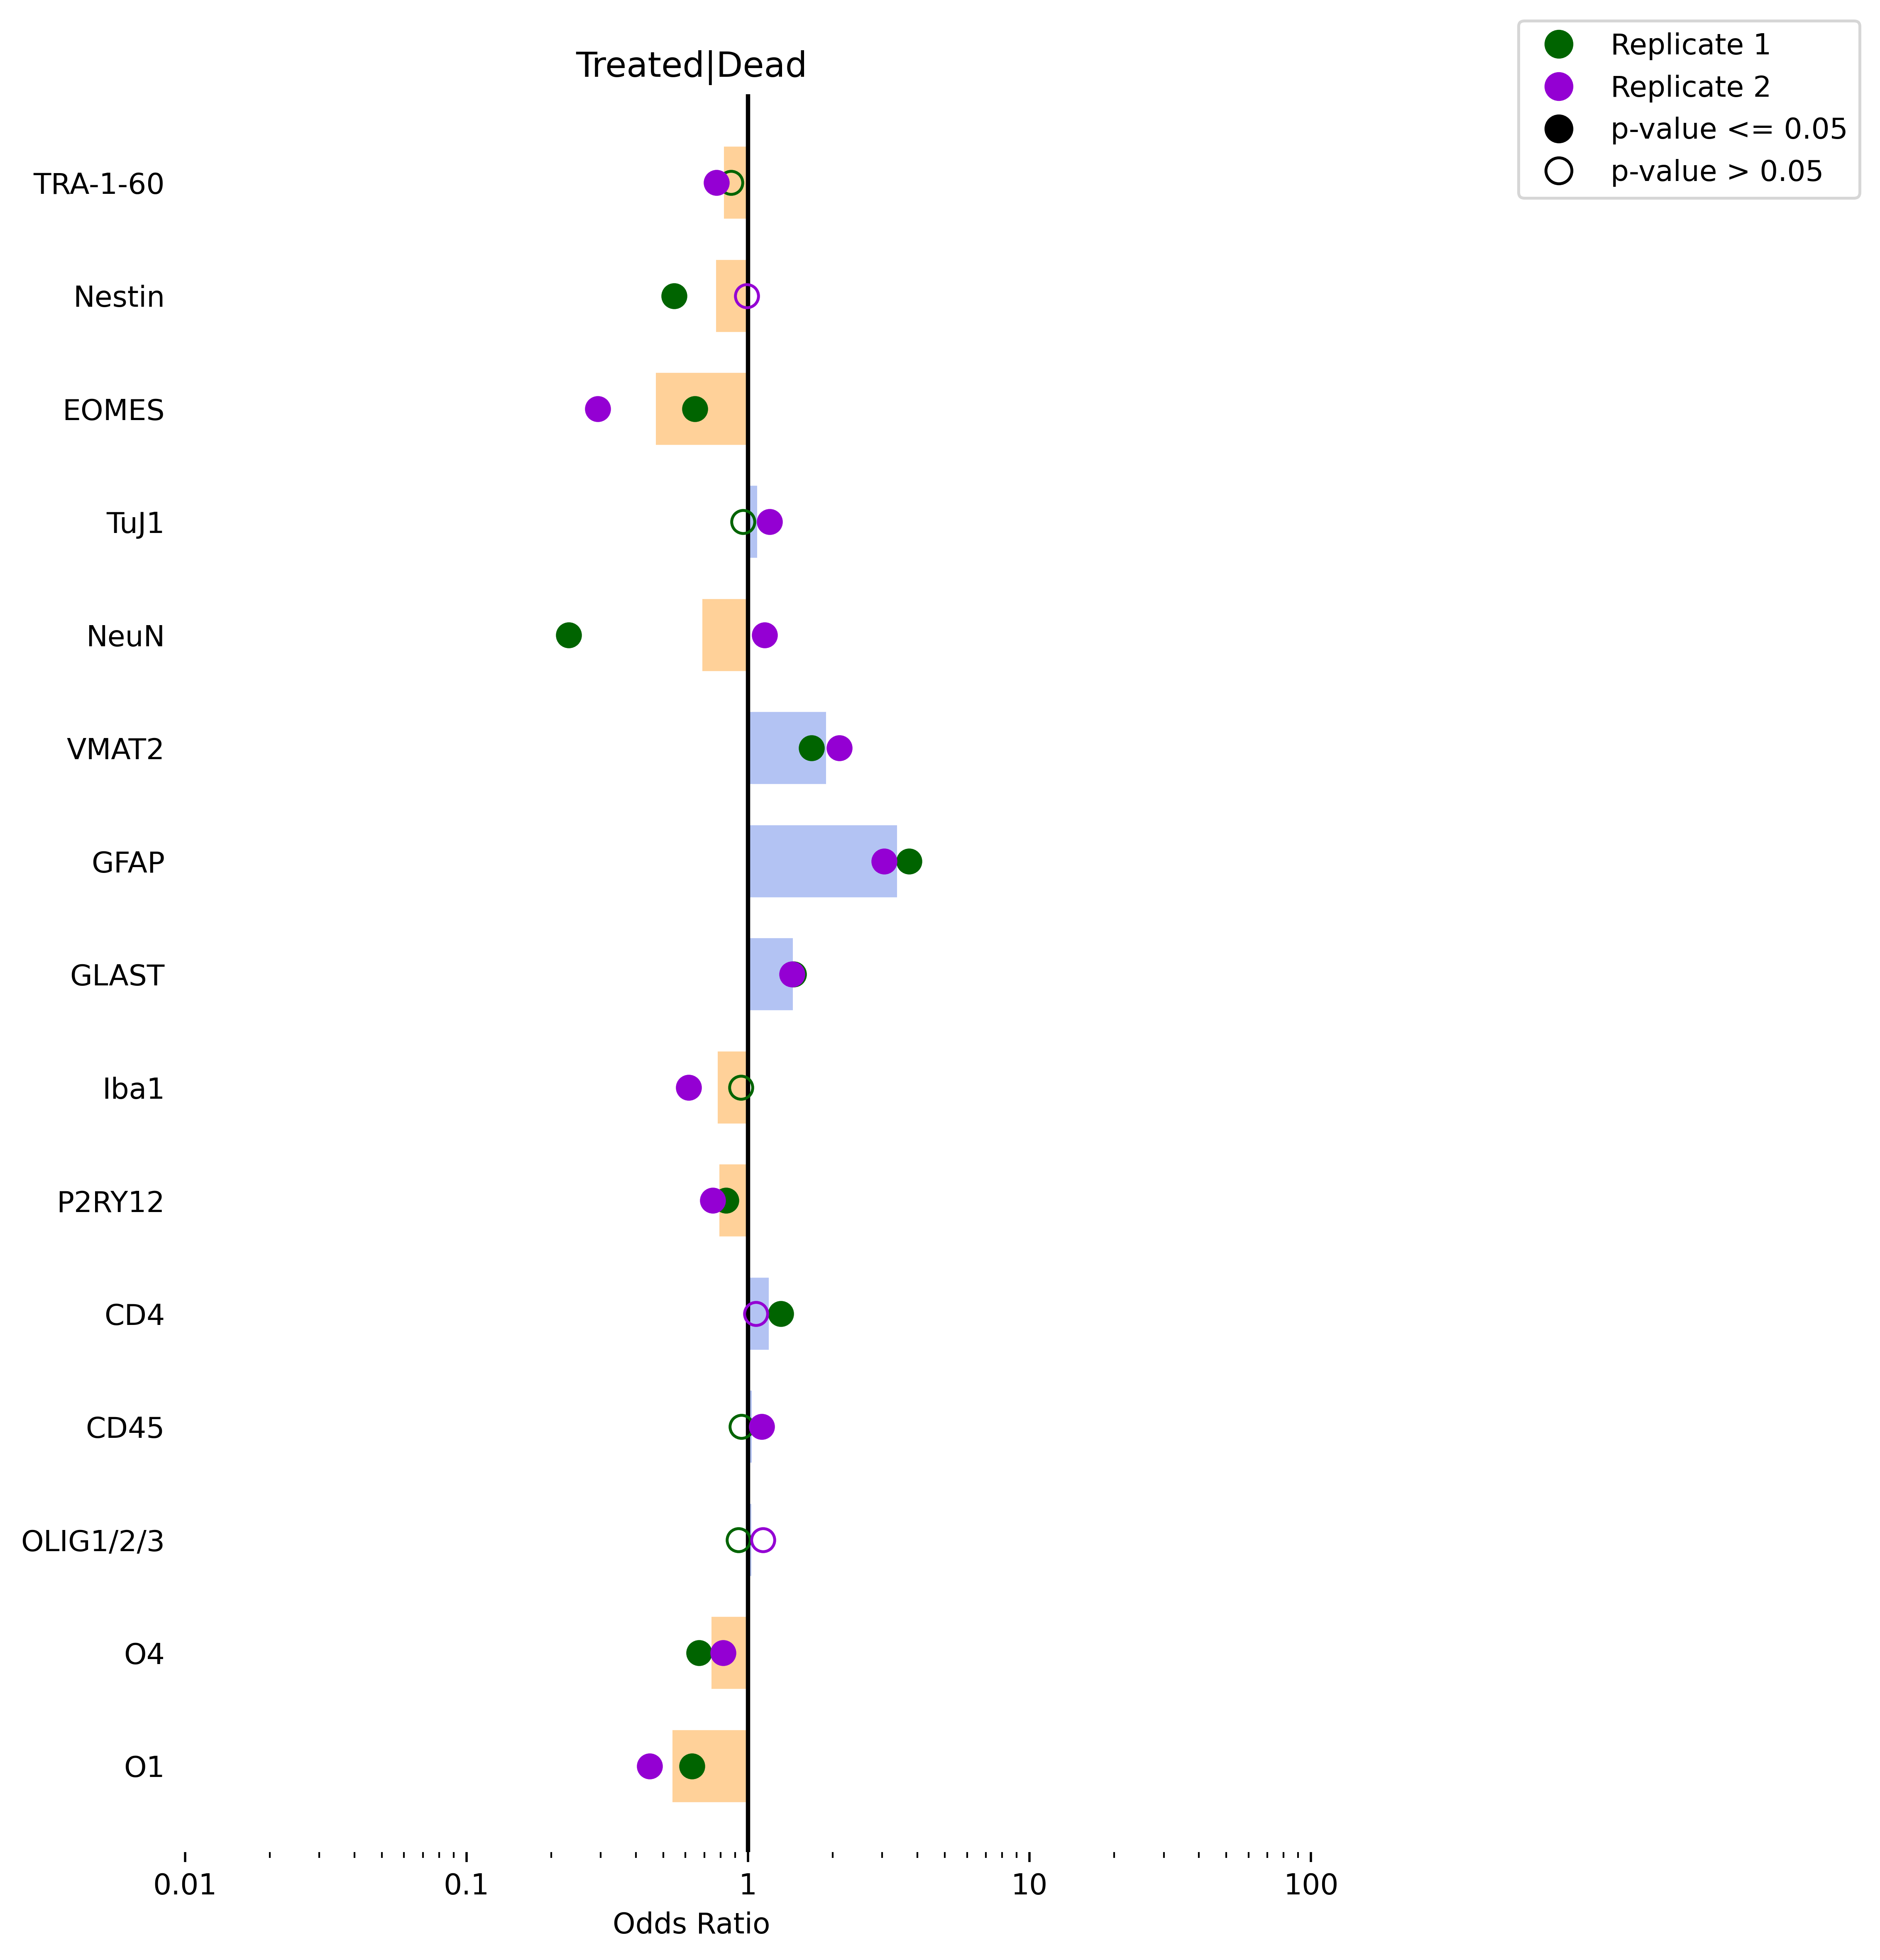

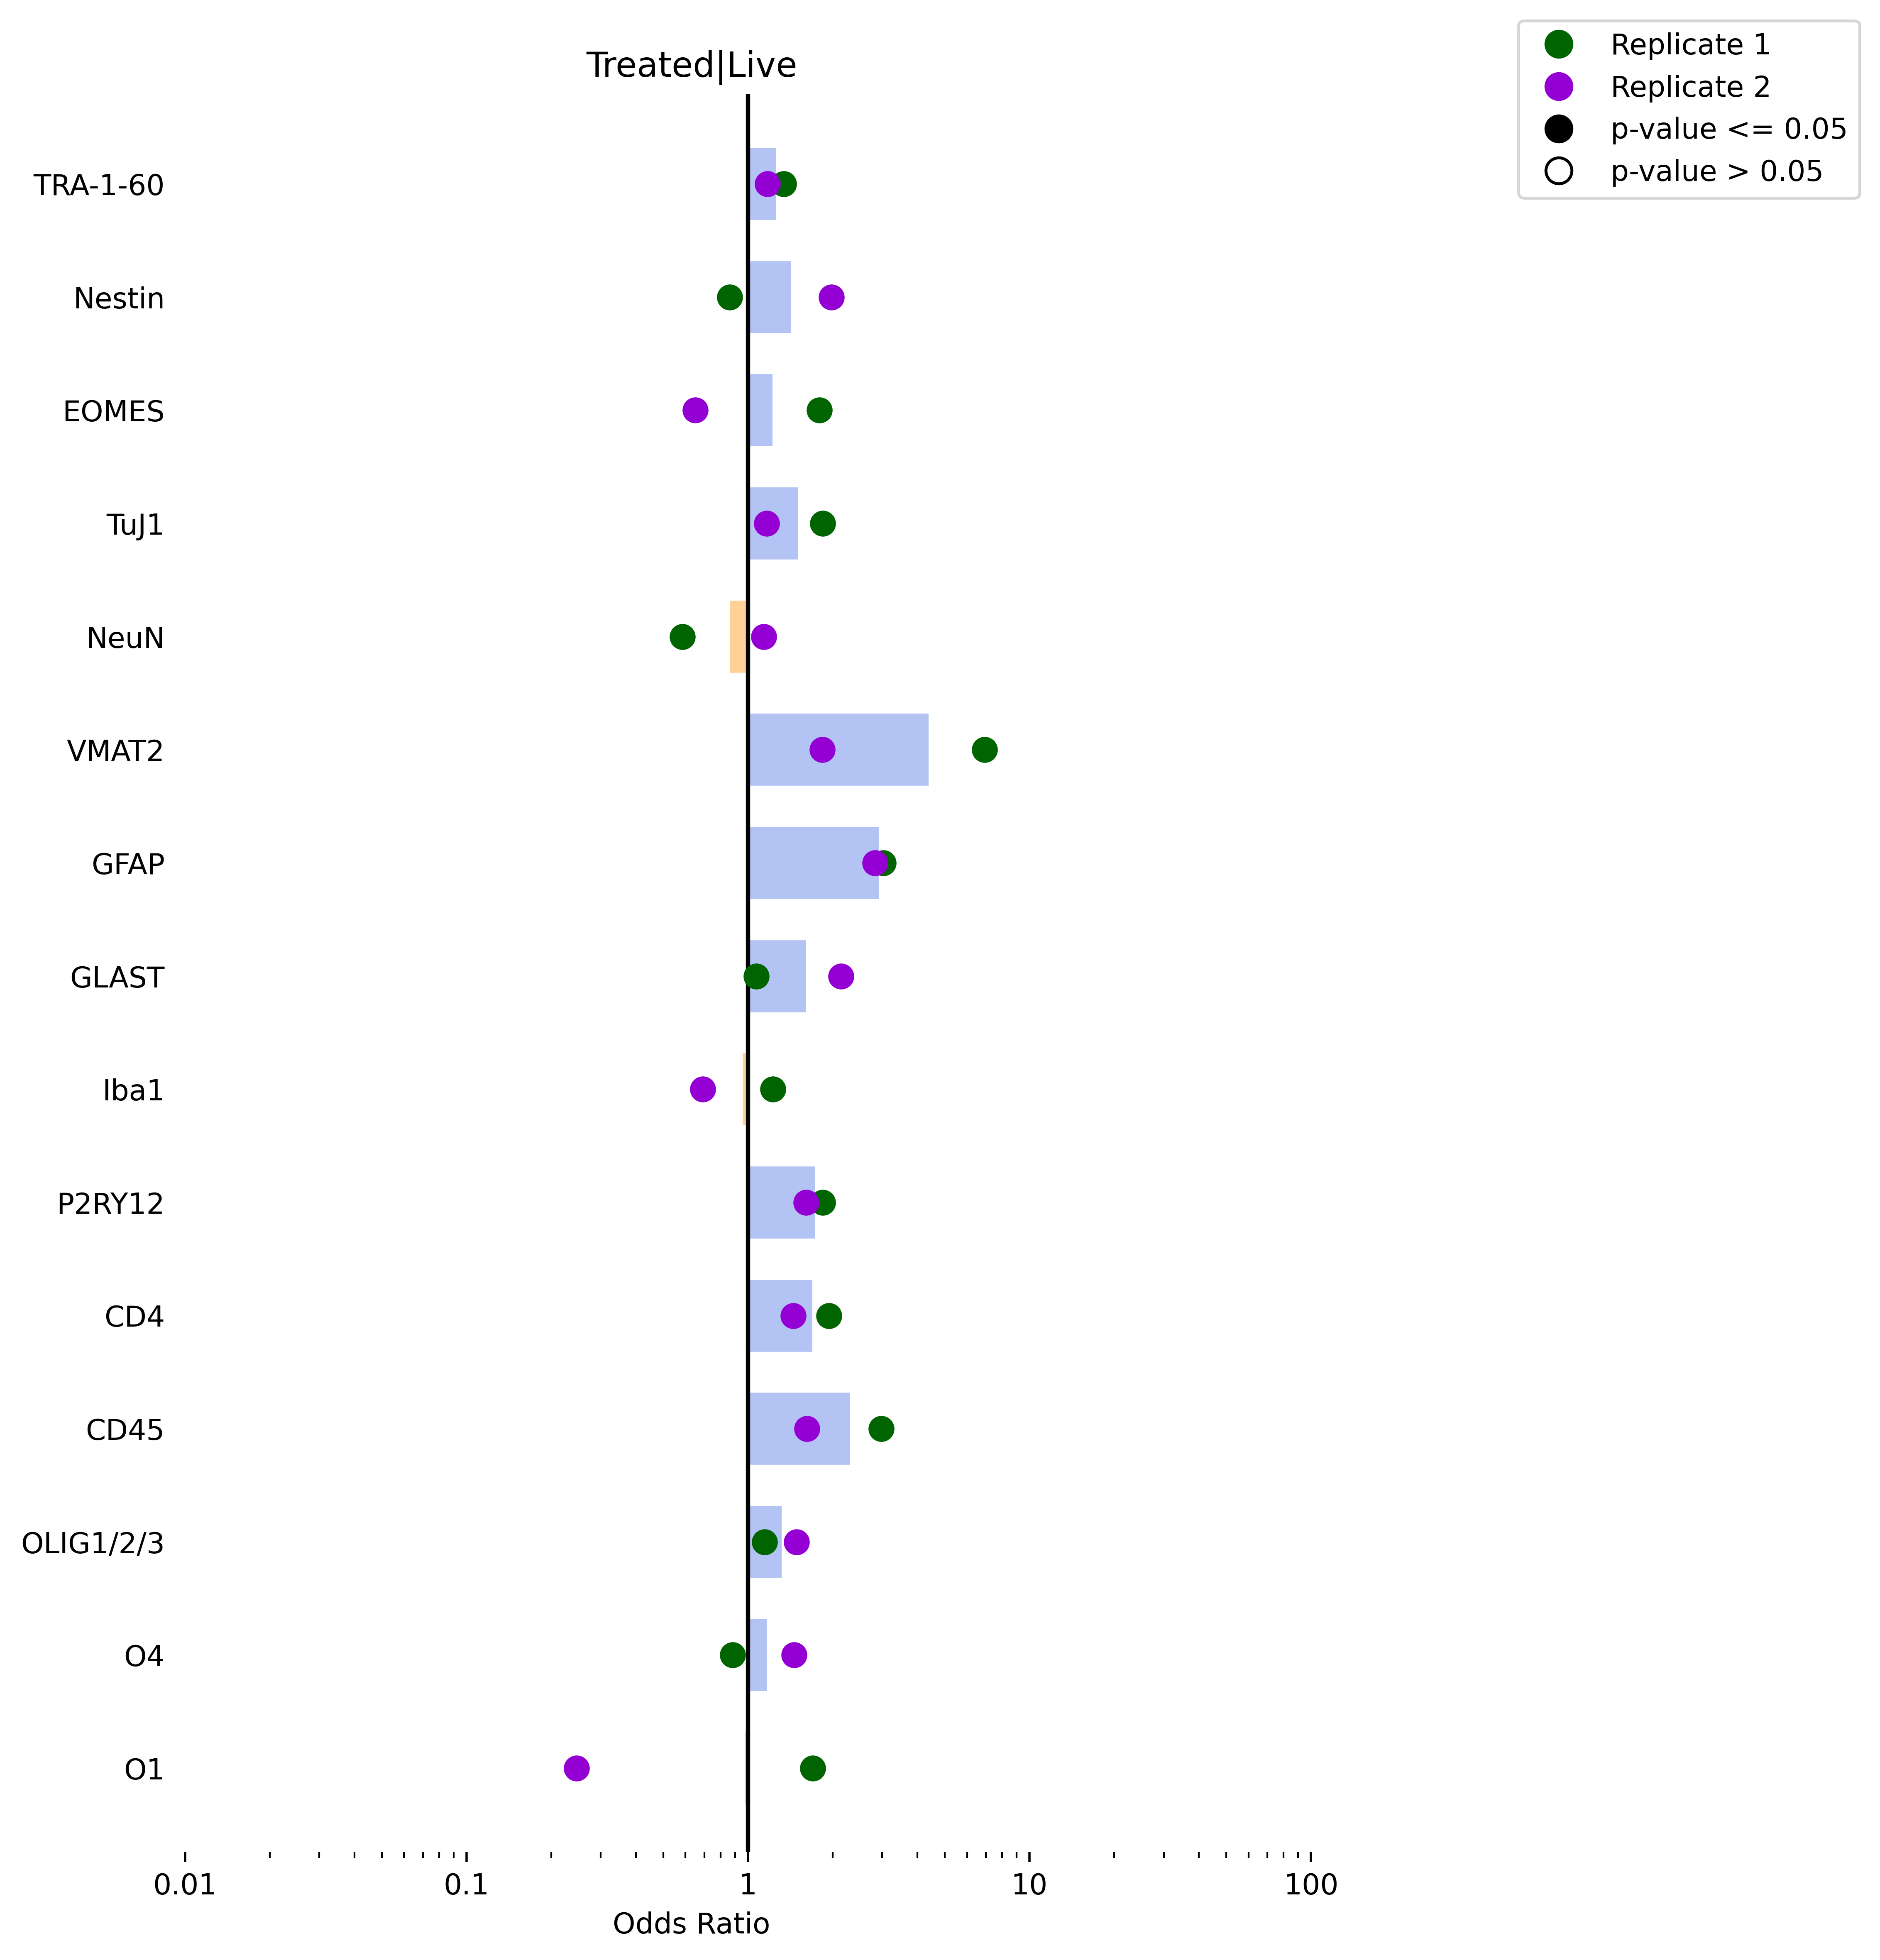

In [17]:
df = pd.read_csv(f'HSV1_Results/liveDead_cells_odds_ratios.csv')
df = df.replace('OLIG1:2:3', 'OLIG1/2/3')
for analysis in df.Viable.unique():
    
    for condition in pd.unique(df[df.Condition!='Mock'].Condition):

        overall_df =  df[(df.Viable ==analysis) & (df.Condition == condition)]
        overall_df.OR = overall_df.OR.replace({np.inf: max(overall_df[overall_df.OR!=np.inf].OR)})
        summary_df = overall_df.groupby('Marker').OR.agg('mean').reset_index()
        summary_df['Color'] = ['darkorange' if c < 1 else 'royalblue' for c in summary_df['OR']]

        summary_df.Marker = pd.Categorical(summary_df.Marker, ['Aβ42', 'p-Tau', 'TRA-1-60','Nestin', 'EOMES','TuJ1','NeuN','VMAT2','GFAP','GLAST', 'Iba1', 'P2RY12', 'CD4','CD45', 'OLIG1/2/3', 'O4', 'O1', 'FOXA2'  ])
        summary_df = summary_df.sort_values('Marker')

        plt.figure(figsize=(7,11), dpi=500)
        for index, row in summary_df.iterrows():
            plt.hlines(y=row.Marker, xmin=1, xmax=row.OR, color=row.Color, linewidth=25, alpha=0.4)
        plt.axvline(1, color='black')
        plt.gca().set(frame_on=False)
        
        sns.stripplot(x=overall_df['OR'], y = overall_df.Marker, hue=overall_df.Replicate, palette=['darkgreen', 'darkviolet', 'orange', 'blue'], s = 0, alpha = 0.4)
        
        colors = {'Replicate 1': 'darkgreen', 'Replicate 2': 'darkviolet', 'Replicate 3': 'orange', 'Replicate 4': 'blue', 'Rep5': 'lime'}
        
        for index, row in overall_df.iterrows():
            x = row.OR
            y = row.Marker
            color = colors[row.Replicate]
            if row.pval <=0.05:
                face = color
            else:
                face = 'None'
            plt.plot([x],[y], marker = 'o', markerfacecolor=face, markeredgecolor=color, markersize=8)
        
        rep1_marker = matplotlib.lines.Line2D([],[],color='w', marker='o', markerfacecolor=colors['Replicate 1'], label='Replicate 1', markeredgecolor=colors['Replicate 1'])
        rep2_marker = matplotlib.lines.Line2D([],[],color='w', marker='o', markerfacecolor=colors['Replicate 2'], label='Replicate 2', markeredgecolor=colors['Replicate 2'])
        marker_open = matplotlib.lines.Line2D([],[],color='w', marker='o', markerfacecolor='None', label='p-value > 0.05', markeredgecolor='black')
        marker_closed = matplotlib.lines.Line2D([],[],color='w', marker='o', markerfacecolor='black', label='p-value <= 0.05', markeredgecolor='black')
        plt.title(condition + '|' + analysis, x=0.45)
        plt.xscale('log')
        plt.ylabel(None)
        plt.xlabel('Odds Ratio', x=0.45)
        plt.gca().yaxis.set_tick_params(width=0)
        handles, labels = [],[]
        handles.append(rep1_marker)
        handles.append(rep2_marker)
        handles.append(marker_closed)
        handles.append(marker_open)
        labels.append('Replicate 1')
        labels.append('Replicate 2')
        labels.append('p-value <= 0.05')
        labels.append('p-value > 0.05')

        plt.gca().legend(handles=handles[0:], labels=labels[0:],bbox_to_anchor=(1.5, 1.05), markerscale = 1.5)


        plt.xticks(ticks = [0.01,
                            0.1,
                            1,
                            10,
                            100],
                   labels = ['0.01',
                            '0.1',
                            '1',
                            '10',
                            '100'])
        plt.savefig(f'HSV1_Results/{condition}_{analysis}_OR_plot.png', bbox_inches='tight', dpi=700)
        plt.show()
        